# Titanic

Start by importing python libraries, that will be required. 

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import re
import imageio
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import csv
import sys
import tarfile
import random
from IPython.display import display, Image
from matplotlib.ticker import MaxNLocator
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Machine Learning Algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

# Reading in the data

Read the data from the CSVs into data structures. Also just shuffle the input data at this step.

In [2]:
not_submit_data = pd.read_csv("train.csv")
submit_data = pd.read_csv("test.csv")

not_submit_data = not_submit_data.sample(frac=1)

datasets = [not_submit_data, submit_data]

# Taking a peak at the data

Take a look at the data and see how many unique values we have for each column also probably want to check to see if we have NaN values. Look at some other functions to see what our data sorta looks like in terms of values. 

In [3]:
not_submit_data.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
328,329,1,3,"Goldsmith, Mrs. Frank John (Emily Alice Brown)",female,31.0,1,1,363291,20.5250,NaN,S
612,613,1,3,"Murphy, Miss. Margaret Jane",female,NaN,1,0,367230,15.5000,NaN,Q
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
89,90,0,3,"Celotti, Mr. Francesco",male,24.0,0,0,343275,8.0500,NaN,S
161,162,1,2,"Watt, Mrs. James (Elizabeth ""Bessie"" Inglis Mi...",female,40.0,0,0,C.A. 33595,15.7500,NaN,S


In [4]:
not_submit_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 328 to 515
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 90.5+ KB


In [5]:
# This will describe all the continous variables
not_submit_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
# Will give some statstics about discrete variables. 
not_submit_data.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"O'Connor, Mr. Maurice",male,CA. 2343,G6,S
freq,1,577,7,4,644


In [7]:
not_submit_data[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


# Feature Engineering

It might be usefull to take create a feature based on the __title of the name__.

In [8]:
for dataset in datasets:
    names = dataset.loc[:, "Name"]
    name = names[0]
    
    titles = []
    for name in names:
        title = re.match(".*, (\w+\s*\w*\.) .*", name)
        titles.append(title.group(1))
        
    dataset.loc[:, "Title"] = titles
    
    dataset['Title'] = dataset['Title'].replace(['Lady.', 'Countess.','Capt.', 'Col.',\
                                                 'Don.', 'Dr.', 'Major.', 'Rev.', 'Sir.', 'Jonkheer.', 'Dona.'], 'Rare')

    # Fix some of the broken data
    dataset['Title'] = dataset['Title'].replace('Mlle.', 'Miss.')
    dataset['Title'] = dataset['Title'].replace('Ms.', 'Miss.')
    dataset['Title'] = dataset['Title'].replace('Mme.', 'Mrs.')

    
title_count = not_submit_data.loc[:, ["Title", "PassengerId"]].groupby(["Title"]).count()
title_survived_mean = not_submit_data.loc[:, ["Title", "Survived"]].groupby(["Title"]).mean()

pd.merge(title_count, title_survived_mean, on="Title")

,PassengerId,Survived
Title,,
Master.,40,0.575000
Miss.,185,0.702703
Mr.,517,0.156673
Mrs.,126,0.793651
Rare,22,0.318182
the Countess.,1,1.000000


I think I will try and create some sort of feature on where the room was located in the ship, specifically where the floor they were staying at was located.

In [9]:
for dataset in datasets:
    dataset["CabinSection"] = dataset["Cabin"][dataset["Cabin"].notnull()].str.extract('\s*(\w).*')
    dataset.loc[dataset["Cabin"].isnull(), "CabinSection"] = "Unknown"
    
not_submit_data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,CabinSection
328,329,1,3,"Goldsmith, Mrs. Frank John (Emily Alice Brown)",female,31.0,1,1,363291,20.5250,NaN,S,Mrs.,Unknown
612,613,1,3,"Murphy, Miss. Margaret Jane",female,NaN,1,0,367230,15.5000,NaN,Q,Miss.,Unknown
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,Mr.,Unknown
89,90,0,3,"Celotti, Mr. Francesco",male,24.0,0,0,343275,8.0500,NaN,S,Mr.,Unknown
161,162,1,2,"Watt, Mrs. James (Elizabeth ""Bessie"" Inglis Mi...",female,40.0,0,0,C.A. 33595,15.7500,NaN,S,Mrs.,Unknown
449,450,1,1,"Peuchen, Major. Arthur Godfrey",male,52.0,0,0,113786,30.5000,C104,S,Rare,C
427,428,1,2,"Phillips, Miss. Kate Florence (""Mrs Kate Louis...",female,19.0,0,0,250655,26.0000,NaN,S,Miss.,Unknown
265,266,0,2,"Reeves, Mr. David",male,36.0,0,0,C.A. 17248,10.5000,NaN,S,Mr.,Unknown
310,311,1,1,"Hays, Miss. Margaret Bechstein",female,24.0,0,0,11767,83.1583,C54,C,Miss.,C
37,38,0,3,"Cann, Mr. Ernest Charles",male,21.0,0,0,A./5. 2152,8.0500,NaN,S,Mr.,Unknown


Let's see if this feature does us any good.

In [10]:
not_submit_data[["CabinSection", "Survived"]].groupby("CabinSection").mean()

,Survived
CabinSection,
A,0.466667
B,0.744681
C,0.593220
D,0.757576
E,0.750000
F,0.615385
G,0.500000
T,0.000000
Unknown,0.299854


Interesting, it seems like if the cabin number was not known then the survival rate goes down buy a large amount. This is likely because if the individuals passed away then they could not verify there cabin number. 

In [11]:
for dataset in datasets:
    dataset.loc[dataset["CabinSection"] != "Unknown", "CabinSection"] = "Known"
    
not_submit_data[["CabinSection", "Survived"]].groupby("CabinSection").mean()

,Survived
CabinSection,
Known,0.666667
Unknown,0.299854


Now this is a beautiful feature! Going to create one more based on family size.

In [12]:
for dataset in datasets:
    dataset.loc[:,"FamilySize"] = dataset.loc[:,"SibSp"] + dataset.loc[:,"Parch"]
    
not_submit_data[not_submit_data["FamilySize"] > 0].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,CabinSection,FamilySize
328,329,1,3,"Goldsmith, Mrs. Frank John (Emily Alice Brown)",female,31.0,1,1,363291,20.5250,NaN,S,Mrs.,Unknown,2
612,613,1,3,"Murphy, Miss. Margaret Jane",female,NaN,1,0,367230,15.5000,NaN,Q,Miss.,Unknown,1
860,861,0,3,"Hansen, Mr. Claus Peter",male,41.0,2,0,350026,14.1083,NaN,S,Mr.,Unknown,2
183,184,1,2,"Becker, Master. Richard F",male,1.0,2,1,230136,39.0000,F4,S,Master.,Known,3
73,74,0,3,"Chronopoulos, Mr. Apostolos",male,26.0,1,0,2680,14.4542,NaN,C,Mr.,Unknown,1


In [13]:
male_survival = not_submit_data.loc[not_submit_data["Sex"] == "male", ["FamilySize", "Survived"]].groupby("FamilySize").mean()
female_survival = not_submit_data.loc[not_submit_data["Sex"] == "female", ["FamilySize", "Survived"]].groupby("FamilySize").mean()

male_survival.rename(columns={"Survived": "Male Survival Rate"}, inplace=True)
female_survival.rename(columns={"Survived": "Female Survival Rate"}, inplace=True)

male_survival.join(female_survival)

,Male Survival Rate,Female Survival Rate
FamilySize,,
0,0.155718,0.785714
1,0.243243,0.816092
2,0.396226,0.775510
3,0.500000,0.842105
4,0.000000,0.250000
5,0.000000,0.375000
6,0.250000,0.375000
7,0.000000,0.000000
10,0.000000,0.000000


Wow, another beautiful feature! Could it even get any better!

In [14]:
for dataset in datasets:
    dataset.loc[dataset["Age"].isnull(), "WasAgeKnown"] = False
    dataset.loc[dataset["Age"].notnull(), "WasAgeKnown"] = True
    
not_submit_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,CabinSection,FamilySize,WasAgeKnown
328,329,1,3,"Goldsmith, Mrs. Frank John (Emily Alice Brown)",female,31.0,1,1,363291,20.5250,NaN,S,Mrs.,Unknown,2,True
612,613,1,3,"Murphy, Miss. Margaret Jane",female,NaN,1,0,367230,15.5000,NaN,Q,Miss.,Unknown,1,False
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,Mr.,Unknown,0,False
89,90,0,3,"Celotti, Mr. Francesco",male,24.0,0,0,343275,8.0500,NaN,S,Mr.,Unknown,0,True
161,162,1,2,"Watt, Mrs. James (Elizabeth ""Bessie"" Inglis Mi...",female,40.0,0,0,C.A. 33595,15.7500,NaN,S,Mrs.,Unknown,0,True


In [15]:
not_submit_data[["WasAgeKnown", "Survived"]].groupby("WasAgeKnown").mean()

,Survived
WasAgeKnown,
False,0.293785
True,0.406162


This one is a little more dissapointing, maybe it's useful not 100% sure. Going to do one more on if the passenger was alone or not. I saw this in some tutorials after the fact.

In [16]:
for dataset in datasets:
    dataset["IsAlone"] = 0
    dataset.loc[dataset["FamilySize"] != 1, "IsAlone"] = 1
    
not_submit_data.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,CabinSection,FamilySize,WasAgeKnown,IsAlone
328,329,1,3,"Goldsmith, Mrs. Frank John (Emily Alice Brown)",female,31.0,1,1,363291,20.5250,NaN,S,Mrs.,Unknown,2,True,1
612,613,1,3,"Murphy, Miss. Margaret Jane",female,NaN,1,0,367230,15.5000,NaN,Q,Miss.,Unknown,1,False,0
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,Mr.,Unknown,0,False,1


In [17]:
not_submit_data[["IsAlone", "Survived"]].groupby("IsAlone").mean()

,Survived
IsAlone,
0,0.552795
1,0.346575


# Cleaning of the data

I need to do some cleaning of the data. For example there are some NaN values which we should remove from there.

In [18]:
# Fix the NaN values.
age_median = not_submit_data["Age"].median()
not_submit_data.loc[:, "Age"] = not_submit_data.loc[:, "Age"].fillna(age_median)

age_median = submit_data["Age"].median()
submit_data.loc[:, "Age"] = submit_data.loc[:, "Age"].fillna(age_median)

age_median = submit_data["Fare"].median()
submit_data.loc[:, "Fare"] = submit_data.loc[:, "Fare"].fillna(age_median)

not_submit_data.loc[:, "Cabin"] = not_submit_data.loc[:, "Cabin"].fillna("Unknown")
submit_data.loc[:, "Cabin"] = submit_data.loc[:, "Cabin"].fillna("Unkown")

not_submit_data.loc[:, "Embarked"] = not_submit_data.loc[:, "Embarked"].fillna("Unknown")
submit_data.loc[:, "Embarked"] = submit_data.loc[:, "Embarked"].fillna("Unknown")

not_submit_data.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,CabinSection,FamilySize,WasAgeKnown,IsAlone
328,329,1,3,"Goldsmith, Mrs. Frank John (Emily Alice Brown)",female,31.0,1,1,363291,20.5250,Unknown,S,Mrs.,Unknown,2,True,1
612,613,1,3,"Murphy, Miss. Margaret Jane",female,28.0,1,0,367230,15.5000,Unknown,Q,Miss.,Unknown,1,False,0
5,6,0,3,"Moran, Mr. James",male,28.0,0,0,330877,8.4583,Unknown,Q,Mr.,Unknown,0,False,1
89,90,0,3,"Celotti, Mr. Francesco",male,24.0,0,0,343275,8.0500,Unknown,S,Mr.,Unknown,0,True,1
161,162,1,2,"Watt, Mrs. James (Elizabeth ""Bessie"" Inglis Mi...",female,40.0,0,0,C.A. 33595,15.7500,Unknown,S,Mrs.,Unknown,0,True,1


# Visualising the Data

Start graphing the data and try and make any insights possible. 

### Age

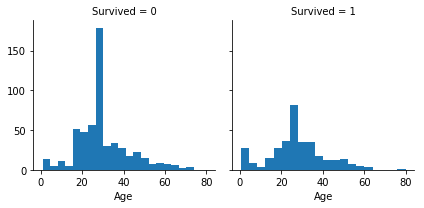

In [19]:
g = sns.FacetGrid(not_submit_data, col='Survived')
g.map(plt.hist, 'Age', bins=20)

Seems like age did play a difference, that older and younger survived. The middle aged people did not quite do as well. 

### Pclass

We do not need to visualize because we have done some analysis before that has assured us it made a difference.

### Sex

We want to keep this in our model.

### Embarked

We definietly want to graph this one out.

In [20]:
not_submit_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,CabinSection,FamilySize,WasAgeKnown,IsAlone
328,329,1,3,"Goldsmith, Mrs. Frank John (Emily Alice Brown)",female,31.0,1,1,363291,20.5250,Unknown,S,Mrs.,Unknown,2,True,1
612,613,1,3,"Murphy, Miss. Margaret Jane",female,28.0,1,0,367230,15.5000,Unknown,Q,Miss.,Unknown,1,False,0
5,6,0,3,"Moran, Mr. James",male,28.0,0,0,330877,8.4583,Unknown,Q,Mr.,Unknown,0,False,1
89,90,0,3,"Celotti, Mr. Francesco",male,24.0,0,0,343275,8.0500,Unknown,S,Mr.,Unknown,0,True,1
161,162,1,2,"Watt, Mrs. James (Elizabeth ""Bessie"" Inglis Mi...",female,40.0,0,0,C.A. 33595,15.7500,Unknown,S,Mrs.,Unknown,0,True,1


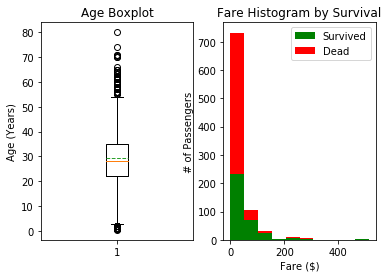

In [21]:
fig, axes = plt.subplots(1, 2)
ax0 = axes[0]

ax0.boxplot(not_submit_data['Age'], showmeans = True, meanline = True)
ax0.set_title('Age Boxplot')
ax0.set_ylabel('Age (Years)')

ax1 = axes[1]
ax1.hist(x = [not_submit_data[not_submit_data['Survived']==1]['Fare'], not_submit_data[not_submit_data['Survived']==0]['Fare']], 
         stacked=True, color = ['g','r'],label = ['Survived','Dead'])
ax1.set_title('Fare Histogram by Survival')
ax1.set_xlabel('Fare ($)')
ax1.set_ylabel('# of Passengers')
ax1.legend()

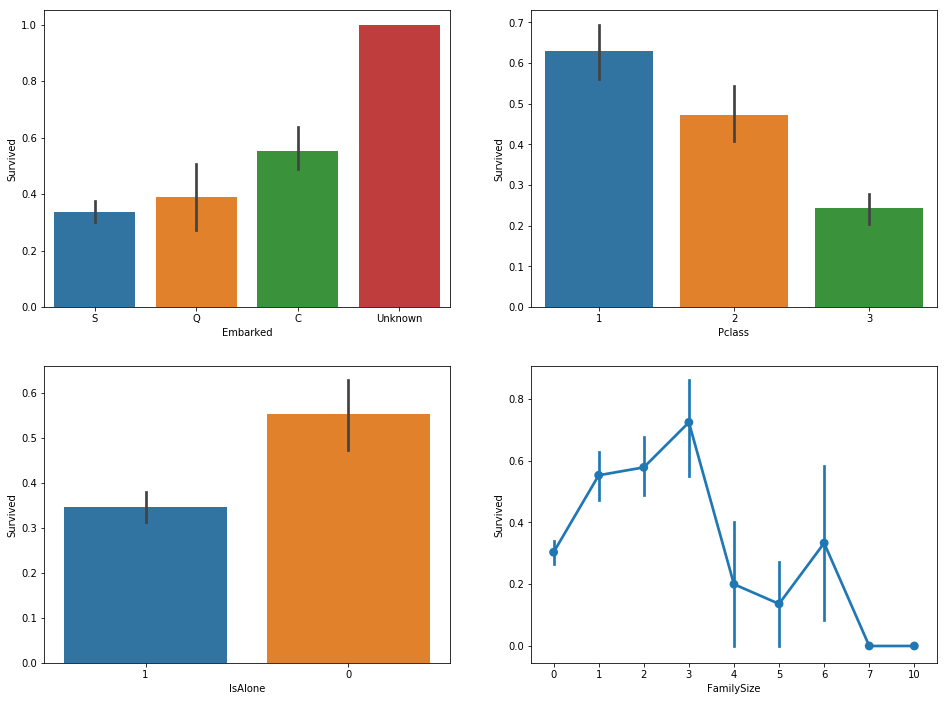

In [22]:
#graph individual features by survival
fig, saxis = plt.subplots(2, 2,figsize=(16,12))

sns.barplot(x = 'Embarked', y = 'Survived', data=not_submit_data, ax = saxis[0,0])
sns.barplot(x = 'Pclass', y = 'Survived', order=[1,2,3], data=not_submit_data, ax = saxis[0,1])

sns.barplot(x = 'IsAlone', y = 'Survived', order=[1,0], data=not_submit_data, ax = saxis[1,0])
sns.pointplot(x = 'FamilySize', y = 'Survived', data=not_submit_data, ax = saxis[1,1])

### Create some coded variables for our correlation graph

In [23]:
#code categorical data
label = LabelEncoder()
for dataset in datasets:    
    dataset['Sex_Code'] = label.fit_transform(dataset['Sex'])
    dataset['Embarked_Code'] = label.fit_transform(dataset['Embarked'])
    dataset['Title_Code'] = label.fit_transform(dataset['Title'])
    
not_submit_data.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,CabinSection,FamilySize,WasAgeKnown,IsAlone,Sex_Code,Embarked_Code,Title_Code
328,329,1,3,"Goldsmith, Mrs. Frank John (Emily Alice Brown)",female,31.0,1,1,363291,20.5250,Unknown,S,Mrs.,Unknown,2,True,1,0,2,3
612,613,1,3,"Murphy, Miss. Margaret Jane",female,28.0,1,0,367230,15.5000,Unknown,Q,Miss.,Unknown,1,False,0,0,1,1
5,6,0,3,"Moran, Mr. James",male,28.0,0,0,330877,8.4583,Unknown,Q,Mr.,Unknown,0,False,1,1,1,2


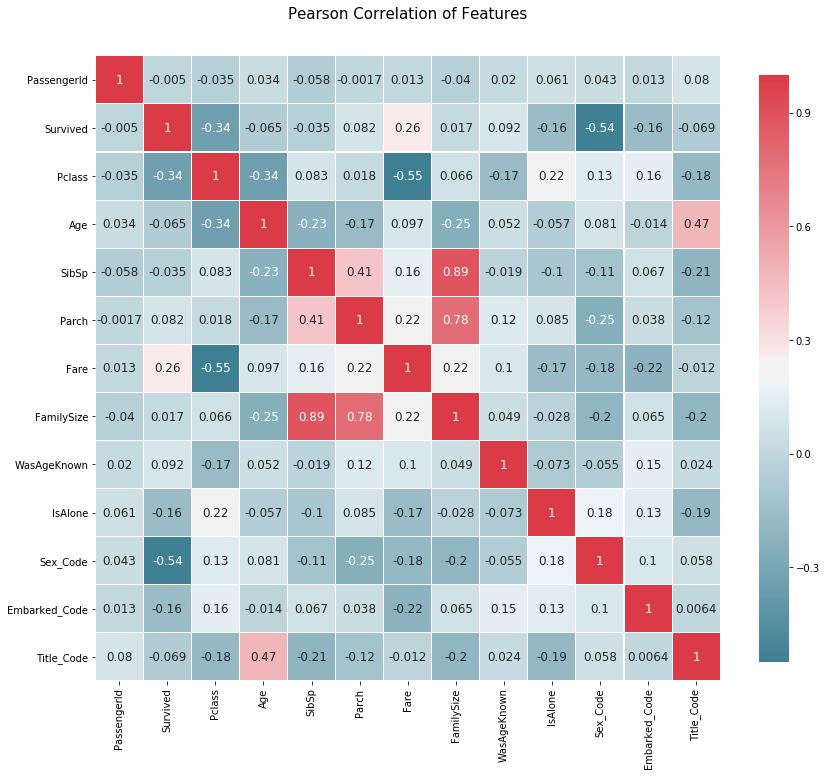

In [24]:
#correlation heatmap of dataset
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(not_submit_data)

# Removal of Un-nessesary Columns

In [25]:
columns_to_remove = ['PassengerId','Parch', 'SibSp', 'Ticket', 'Cabin', 'Name']

not_submit_data = not_submit_data.drop(columns_to_remove, axis=1)
submit_data = submit_data.drop(columns_to_remove, axis=1)

datasets = [not_submit_data, submit_data]

not_submit_data.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,CabinSection,FamilySize,WasAgeKnown,IsAlone,Sex_Code,Embarked_Code,Title_Code
328,1,3,female,31.0,20.5250,S,Mrs.,Unknown,2,True,1,0,2,3
612,1,3,female,28.0,15.5000,Q,Miss.,Unknown,1,False,0,0,1,1
5,0,3,male,28.0,8.4583,Q,Mr.,Unknown,0,False,1,1,1,2
89,0,3,male,24.0,8.0500,S,Mr.,Unknown,0,True,1,1,2,2
161,1,2,female,40.0,15.7500,S,Mrs.,Unknown,0,True,1,0,2,3


In [26]:
submit_data.head()

,Pclass,Sex,Age,Fare,Embarked,Title,CabinSection,FamilySize,WasAgeKnown,IsAlone,Sex_Code,Embarked_Code,Title_Code
0,3,male,34.5,7.8292,Q,Mr.,Unknown,0,True,1,1,1,2
1,3,female,47.0,7.0000,S,Mrs.,Unknown,1,True,0,0,2,3
2,2,male,62.0,9.6875,Q,Mr.,Unknown,0,True,1,1,1,2
3,3,male,27.0,8.6625,S,Mr.,Unknown,0,True,1,1,2,2
4,3,female,22.0,12.2875,S,Mrs.,Unknown,2,True,1,0,2,3


# Create Dummy Variables

We want to create the dummy variables so that the model is able to train better.

In [27]:
not_submit_data = pd.get_dummies(not_submit_data)
submit_data = pd.get_dummies(submit_data)

datasets = [not_submit_data, submit_data]

not_submit_data.head()

,Survived,Pclass,Age,Fare,FamilySize,WasAgeKnown,IsAlone,Sex_Code,Embarked_Code,Title_Code,...,Embarked_S,Embarked_Unknown,Title_Master.,Title_Miss.,Title_Mr.,Title_Mrs.,Title_Rare,Title_the Countess.,CabinSection_Known,CabinSection_Unknown
328,1,3,31.0,20.5250,2,True,1,0,2,3,...,1,0,0,0,0,1,0,0,0,1
612,1,3,28.0,15.5000,1,False,0,0,1,1,...,0,0,0,1,0,0,0,0,0,1
5,0,3,28.0,8.4583,0,False,1,1,1,2,...,0,0,0,0,1,0,0,0,0,1
89,0,3,24.0,8.0500,0,True,1,1,2,2,...,1,0,0,0,1,0,0,0,0,1
161,1,2,40.0,15.7500,0,True,1,0,2,3,...,1,0,0,0,0,1,0,0,0,1


# Splitting of the data

I need to load and look at the shape of the data. Also, we do not have prediction labels for the test_data. So we can split the train data into test and validation data as well. 

In [28]:
test_data = not_submit_data.iloc[-100:, :]
train_data = not_submit_data.iloc[:-100, :]

x_test = test_data.drop("Survived", axis=1)
y_test = test_data["Survived"]

x_train = train_data.drop("Survived", axis=1)
y_train = train_data["Survived"]

print("X Test Shape: " + str(x_test.shape))
print("Y Test Shape: " + str(y_test.shape))

print("X Train Shape: " + str(x_train.shape))
print("Y Train Shape: " + str(y_train.shape))

X Test Shape: (100, 23)
Y Test Shape: (100,)
X Train Shape: (791, 23)
Y Train Shape: (791,)


# Modeling the data

I will not create models of the data using the following algorithms. I'll be using a training and test set but I won't be doing anything fancy like k-fold cross validation. 

1. Random Forests
2. Decision Trees
3. KNN
4. Support Vector Machines
5. Logistic Regression
6. Naive Bayes

## Random Forests

In [29]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(x_train, y_train)
random_forest.score(x_test, y_test)

0.82

## Decision Trees

In [30]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(x_train, y_train)
decision_tree.score(x_test, y_test)

0.79

## KNN

In [31]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(x_train, y_train)
knn.score(x_test, y_test)

0.79

## Support Machine Vectors

In [32]:
svc = SVC()
svc.fit(x_train, y_train)
svc.score(x_test, y_test)

0.79

## Logistic Regression

In [33]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
logreg.score(x_test, y_test)

0.85

### Measure using correlation of logistic regression using

In [34]:
coeff_df = pd.DataFrame(not_submit_data.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
15,Title_Master.,1.613344
9,Sex_female,1.354157
18,Title_Mrs.,1.009566
21,CabinSection_Known,0.963481
11,Embarked_C,0.792344
12,Embarked_Q,0.445016
7,Embarked_Code,0.313818
4,WasAgeKnown,0.229202
22,CabinSection_Unknown,0.177823
20,Title_the Countess.,0.108345


## Naive Bayes

In [35]:
gaussian = GaussianNB()
gaussian.fit(x_train, y_train)
gaussian.score(x_test, y_test)

0.81

# Conclusion: Use Random Forest

However, going to train on all of the data.

In [36]:
# Need to remove the survived column and also the countess because the submit data does not have any samples with this title
# also need ot remove the unknown in the embarked column because submit data does not have any of this
x_train_full = not_submit_data.drop(["Survived", "Title_the Countess.", "Embarked_Unknown"], axis=1)
y_train_full = not_submit_data["Survived"]

print("X Train Full Shape: " + str(x_train_full.shape))
print("Y Train Full Shape: " + str(y_train_full.shape))

random_forest_final = RandomForestClassifier(n_estimators=100)
random_forest_final.fit(x_train_full, y_train_full)
random_forest_final.score(x_train_full, y_train_full)

y_pred = random_forest_final.predict(submit_data)

X Train Full Shape: (891, 21)
Y Train Full Shape: (891,)


# Generate Final Submit File

In [37]:
submit_data = pd.read_csv("test.csv")

submission = pd.DataFrame({
    "PassengerId": submit_data["PassengerId"],
    "Survived": y_pred
})

submission.to_csv('submission.csv', index=False)